In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from random import sample
from time import process_time

In [2]:
# load in raw dataset
DATA = pd.read_csv('ratings.csv')
N = DATA.shape[0]

In [3]:
# split row indexes into K=5 subsets of equal size
K = 5
Subsets = dict()   # dictionary: subset ID --> a subset of row indexes
pool = [i for i in range(N)]
for subset_ID in range(K-1):
    Subsets[subset_ID] = sample(pool, int(N/K))  # each subset of row indexes is a list
    pool = [i for i in pool if not i in Subsets[subset_ID]]
Subsets[K-1] = pool

# Naive Approaches

In [4]:
def RMSE(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return(np.sqrt(np.mean((v1-v2)**2)))

def Naive_A(TRAIN, TEST):    # predict by overall average rating
    Rating_overall = np.mean(TRAIN.rating)
    RMSE_train = RMSE([Rating_overall] * TRAIN.shape[0], TRAIN.rating)
    RMSE_test = RMSE([Rating_overall] * TEST.shape[0], TEST.rating)
    return (RMSE_train,RMSE_test)

In [5]:
def Naive_B(TRAIN, TEST):   # predict by average rating per User ID
    
    alt = np.mean(TRAIN.rating) # alternative if user not in training set
    
    Rating_user = dict()
    for ID in np.unique(TRAIN.userId):
        data = TRAIN.loc[TRAIN.userId==ID]
        Rating_user[ID] = np.mean(data.rating)
        
    RMSE_train = RMSE([Rating_user[ID] for ID in TRAIN.userId], TRAIN.rating)
    RMSE_test = RMSE([Rating_user.get(ID,alt) for ID in TEST.userId], TEST.rating)
    
    return (RMSE_train, RMSE_test)

In [10]:
def Naive_C(TRAIN, TEST): # predict by average rating per movie ID
    
    alt = np.mean(TRAIN.rating)  # alternative if movie not in training set
    
    Rating_movie = dict()
    for index in np.unique(TRAIN.movieId):
        data = TRAIN.loc[TRAIN.movieId==index]
        Rating_movie[index] = np.mean(data.rating)
        
    RMSE_train = RMSE([Rating_movie[index] for index in TRAIN.movieId], TRAIN.rating)
    RMSE_test = RMSE([Rating_movie.get(index,alt) for index in TEST.movieId], TEST.rating)
    
    return (RMSE_train, RMSE_test)

In [7]:
def Naive_D(TRAIN, TEST): # predict by combined average rating
    
    alt = np.mean(TRAIN.rating) # alternative if user not in training set
    
    Rating_user = dict()   # average rating per user ID
    for ID in np.unique(TRAIN.userId):
        data = TRAIN.loc[TRAIN.userId==ID]
        Rating_user[ID] = np.mean(data.rating)
        
    Rating_movie = dict()  # average rating per movie ID
    for index in np.unique(TRAIN.movieId):
        data = TRAIN.loc[TRAIN.movieId==index]
        Rating_movie[index] = np.mean(data.rating)
        
    # linear regression
    A = [(Rating_user[u],Rating_movie[m]) for u,m in zip(TRAIN.userId,TRAIN.movieId)]
    A = np.hstack((np.ones([len(A),1]), np.array(A)))
    alpha,beta,gamma = np.linalg.lstsq(A, np.array(TRAIN.rating), rcond=None)[0]
    coef = np.array([alpha,beta,gamma]).reshape([3,1])
    
    # compute RMSE
    RMSE_train = RMSE(np.dot(A,coef).flatten() , TRAIN.rating)
    B = [(Rating_user.get(u,alt),Rating_movie.get(m,Rating_user.get(u,alt))) for u,m in zip(TEST.userId,TEST.movieId)]
    B = np.hstack((np.ones([len(B),1]), np.array(B)))
    RMSE_test = RMSE(np.dot(B,coef).flatten() , TEST.rating)
    
    return (RMSE_train, RMSE_test)


In [11]:
timing = list()

NAIVE = dict()
for k in range(K):
    TEST = DATA.loc[Subsets[k],:]
    TRAIN = DATA.loc[[i for i in range(N) if not i in Subsets[k]],:]
    res = [Naive_A(TRAIN,TEST)]
    res.append(Naive_B(TRAIN,TEST))
    res.append(Naive_C(TRAIN,TEST))
    stamp = process_time()
    res.append(Naive_D(TRAIN,TEST))
    timing.append(process_time()-stamp)
    NAIVE[k] = res

# save the results
DF = pd.DataFrame(NAIVE, index=["Naive A","Naive B","Naive C","Naive D"]).transpose()
DF.index = ["k = "+str(k) for k in range(K)]
DF.to_csv("Naive_Performance.csv")
with open("timing.json", "w") as fh:
    json.dump(timing, fh, indent=2)

In [12]:
DF.applymap(lambda a: tuple(round(b,4) for b in a))

,Naive A,Naive B,Naive C,Naive D
k = 0,"(1.0416, 1.0463)","(0.9339, 0.9416)","(0.8687, 0.9774)","(0.8018, 0.8871)"
k = 1,"(1.0448, 1.0334)","(0.9349, 0.9379)","(0.8713, 0.9694)","(0.8026, 0.8837)"
k = 2,"(1.0438, 1.0375)","(0.9349, 0.9375)","(0.8684, 0.9767)","(0.8012, 0.8899)"
k = 3,"(1.0408, 1.0493)","(0.9337, 0.9424)","(0.8683, 0.9782)","(0.8014, 0.8875)"
k = 4,"(1.0417, 1.0461)","(0.9326, 0.9468)","(0.8671, 0.9839)","(0.7995, 0.8974)"


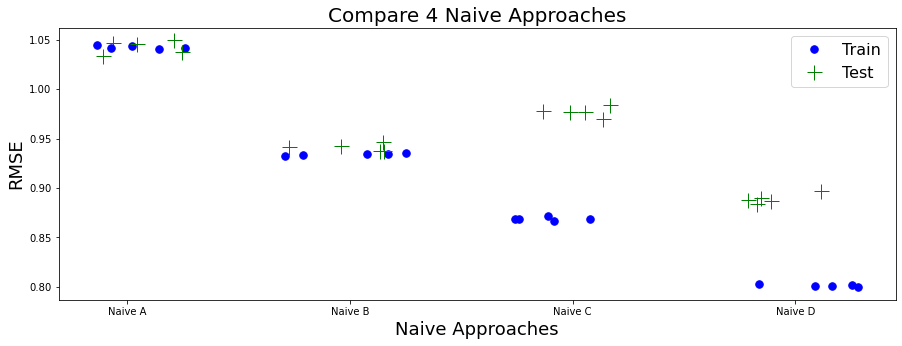

In [15]:
fig,ax = plt.subplots(figsize=(15,5))

for row in DF.index:
    ax.plot(DF.columns, [a for a,b in DF.loc[row,]], 'b.', markersize=15, label="Train" if row=='k = 0' else None)
    ax.plot(DF.columns, [b for a,b in DF.loc[row,]], 'g+', markersize=15, label="Test" if row=='k = 0' else None)

for elements in ax.lines:    # add random noise to x-coordinates of points
    xs = elements.get_xydata()[:, 0] 
    jittered_xs = xs + np.random.uniform(-0.3, 0.3, xs.shape)
    elements.set_xdata(jittered_xs)
ax.relim()
ax.autoscale(enable=True)

plt.xlabel("Naive Approaches", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.title("Compare 4 Naive Approaches", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()